## Load Data

Loading and preparing data is a critical step in the XGBoost modeling process, as it helps to ensure that your model is based on high-quality, relevant data. In this section, we will load the data.

The Bank Marketing dataset from UCI is a popular dataset hsfrequently used in machine learning and data science projects. 

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [1]:
import pandas as pd

In [2]:
bank = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Note: The right-most column, `y`, is the target column: whether someone subscribed or not.  That's what we want to predict.

### EDA

In [4]:
bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
n_rows, n_cols = bank.shape
print(n_rows, n_cols)

41188 21


In [6]:
bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Observations:
* `pdays` is being used as an indicator (max=999)
* `previous` is skewed...mean way different than median (50%)

#### Investigate the correlation coefficients
To be specific, the _Spearman_ correlation coefficients.  It's a _rank_ coefficient...does not assume linearity.  Due to this assumption, any monotonically increasing function--whether it's exponential or logarithmic--would result in a Spearman correlation coefficient of 1.

You are most likely familiar with the _Pearson_ correlation coefficient...assumes linearity.

In [8]:
(bank 
    .assign(success=bank.y == 'yes')
    .corr(method='spearman', numeric_only=True)
    .style
    .background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,success
age,1.000000,-0.002123,0.005715,-0.001062,-0.012643,0.045003,0.044790,0.114536,0.054391,0.044789,-0.011861
duration,-0.002123,1.000000,-0.080953,-0.083072,0.042407,-0.069201,0.002854,-0.008678,-0.078346,-0.095225,0.348777
campaign,0.005715,-0.080953,1.000000,0.055514,-0.087420,0.156360,0.096494,-0.001554,0.140512,0.144264,-0.063668
pdays,-0.001062,-0.083072,0.055514,1.000000,-0.509583,0.227698,0.056763,-0.077265,0.278488,0.290673,-0.324942
previous,-0.012643,0.042407,-0.087420,-0.509583,1.000000,-0.435293,-0.282720,-0.115967,-0.454724,-0.438721,0.200914
emp.var.rate,0.045003,-0.069201,0.156360,0.227698,-0.435293,1.000000,0.664890,0.224693,0.939915,0.944702,-0.247480
cons.price.idx,0.044790,0.002854,0.096494,0.056763,-0.282720,0.664890,1.000000,0.245633,0.490970,0.464738,-0.122187
cons.conf.idx,0.114536,-0.008678,-0.001554,-0.077265,-0.115967,0.224693,0.245633,1.000000,0.236646,0.132707,0.041229
euribor3m,0.054391,-0.078346,0.140512,0.278488,-0.454724,0.939915,0.490970,0.236646,1.000000,0.928857,-0.266822
nr.employed,0.044789,-0.095225,0.144264,0.290673,-0.438721,0.944702,0.464738,0.132707,0.928857,1.000000,-0.283957


NB:  both `Jinja2` and `matplotlib` need to be installed to apply the `background_gradient`

<Axes: >

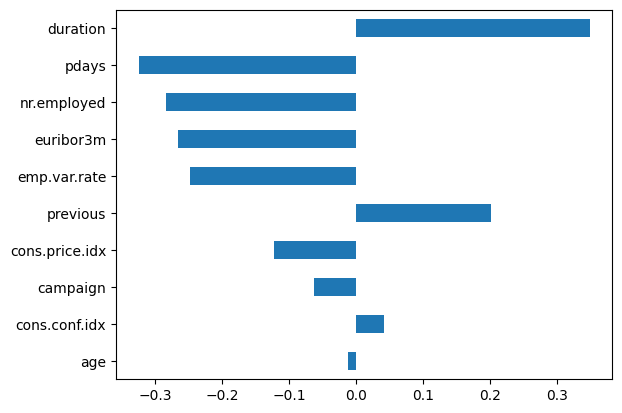

In [18]:
(bank
    .assign(success=bank.y == 'yes')             # make a new column of booleans
    .corr(method='spearman', numeric_only=True)  # calculate the Spearman correlation coefficients for the number-y columns
    .loc[:, 'success']                           # just want the coefficients from the 'success' column
    .iloc[:-1]                                   # but not the trivial one for itself
    .sort_values(key=lambda val: abs(val))       # slick way to order by magnitude
    .plot.barh()                                 # visualize it
)

got lazy...just ran the cells in the supplied course notebook.

Cool thing to remember:  add `.plot.bar()` to `.value_counts()` to get a histogram...looks like `matplotlib` ain't too bad after all.

Also, `.select_dtypes(<type>)` is a slick way to grab like-columns from a df.

#### Crosstab

In [22]:
(pd.crosstab(bank.job, bank.y, normalize='index')
 .style
 .background_gradient(cmap='RdBu', vmin=0, vmax=1, axis='index')
 .format({**{col: '{:.1%}' for col in ['no', 'yes']}})  # extra flair, mudafakah
)

y,no,yes
job,,
admin.,87.0%,13.0%
blue-collar,93.1%,6.9%
entrepreneur,91.5%,8.5%
housemaid,90.0%,10.0%
management,88.8%,11.2%
retired,74.8%,25.2%
self-employed,89.5%,10.5%
services,91.9%,8.1%
student,68.6%,31.4%


<Axes: >

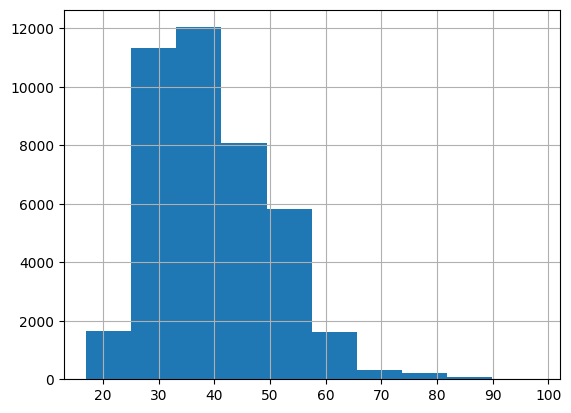

In [23]:
bank.age.hist()

#### Pivot table

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

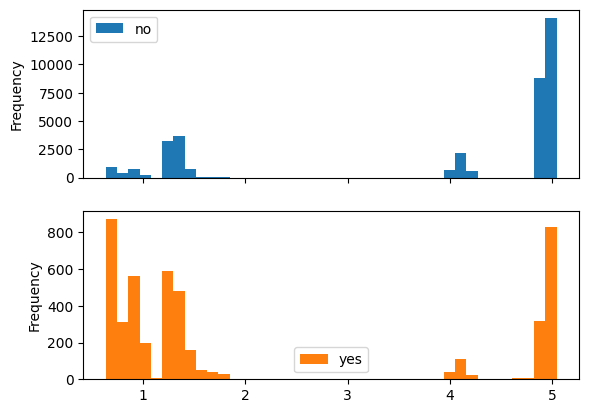

In [30]:
(bank
 .pivot(columns='y', values='euribor3m') 
 .plot.hist(subplots=True, bins=40)
)

In [38]:
(bank
 .groupby('default')
 .describe()
 .stack()
 .unstack(level=0)
 .T
)

count         mean         std       min       25%  \
               default                                                         
age            no       32588.0    39.140635   10.477032    17.000    31.000   
               unknown   8597.0    43.371990    9.488981    19.000    36.000   
               yes          3.0    42.333333    9.814955    31.000    39.500   
duration       no       32588.0   259.842549  261.069492     0.000   103.750   
               unknown   8597.0   252.435035  252.336038     5.000    98.000   
               yes          3.0   103.333333   34.151623    66.000    88.500   
campaign       no       32588.0     2.520744    2.707943     1.000     1.000   
               unknown   8597.0     2.745609    2.987461     1.000     1.000   
               yes          3.0     1.333333    0.577350     1.000     1.000   
pdays          no       32588.0   954.787130  204.815798     0.000   999.000   
               unknown   8597.0   991.606258   85.379354     0.000   999.000   
               yes          3.0   999.000000    0.000000   999.000   999.000   
previous       no       32588.0     0.199030    0.532582     0.000     0.000   
               unknown   8597.0     0.074096    0.292969     0.000     0.000   
               yes          3.0     0.333333    0.577350     0.000     0.000   
emp.var.rate   no       32588.0    -0.082168    1.617598    -3.400    -1.800   
               unknown   8597.0     0.703466    1.190153    -3.400     1.100   
               yes          3.0     0.900000    0.866025    -0.100     0.650   
cons.price.idx no       32588.0    93.525639    0.588528    92.201    93.075   
               unknown   8597.0    93.765365    0.496831    92.201    93.444   
               yes          3.0    93.362667    0.140873    93.200    93.322   
cons.conf.idx  no       32588.0   -40.565469    4.804758   -50.800   -42.700   
               unknown   8597.0   -40.265139    3.878180   -50.000   -42.700   
               yes          3.0   -38.066667    3.406367   -42.000   -39.050   
euribor3m      no       32588.0     3.447246    1.783904     0.634     1.313   
               unknown   8597.0     4.280654    1.341625     0.635     4.856   
               yes          3.0     4.693000    0.467654     4.153     4.558   
nr.employed    no       32588.0  5159.990214   75.795949  4963.600  5099.100   
               unknown   8597.0  5193.725951   48.289122  4963.600  5191.000   
               yes          3.0  5217.333333   18.648414  5195.800  5211.950   

                             50%       75%       max  
               default                                
age            no         37.000    46.000    95.000  
               unknown    43.000    51.000    98.000  
               yes        48.000    48.000    48.000  
duration       no        181.000   321.000  4918.000  
               unknown   175.000   313.000  3366.000  
               yes       111.000   122.000   133.000  
campaign       no          2.000     3.000    43.000  
               unknown     2.000     3.000    56.000  
               yes         1.000     1.500     2.000  
pdays          no        999.000   999.000   999.000  
               unknown   999.000   999.000   999.000  
               yes       999.000   999.000   999.000  
previous       no          0.000     0.000     7.000  
               unknown     0.000     0.000     4.000  
               yes         0.000     0.500     1.000  
emp.var.rate   no          1.100     1.400     1.400  
               unknown     1.400     1.400     1.400  
               yes         1.400     1.400     1.400  
cons.price.idx no         93.444    93.994    94.767  
               unknown    93.918    93.994    94.601  
               yes        93.444    93.444    93.444  
cons.conf.idx  no        -41.800   -36.400   -26.900  
               unknown   -41.800   -36.400   -26.900  
               yes       -36.100   -36.100   -36.100  
euribor3m      no          4.856   

<Axes: xlabel='pdays', ylabel='campaign'>

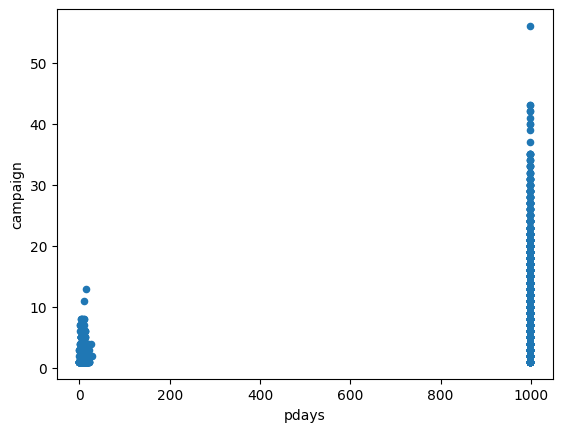

In [39]:
(bank
 .plot.scatter(x='pdays', y='campaign')
)

In [40]:
pd.__version__

'1.5.3'

<Axes: xlabel='pdays', ylabel='campaign'>

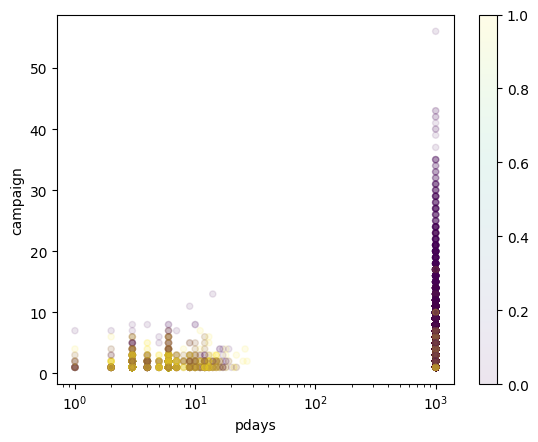

In [59]:
bank = (bank
 .assign(subscribed=(bank.y == 'yes').astype(int))
)

bank.plot.scatter(x='pdays', y='campaign', logx=True, alpha=.1, c=bank.subscribed, cmap='viridis')